#= Quicksort – CI Computation


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
!git clone https://github.com/hanelo/M2-AI-SMPE-2025-HanaeTafza.git


Cloning into 'M2-AI-SMPE-2025-HanaeTafza'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (144/144), done.
Receiving objects: 100% (148/148), 597.80 KiB | 9.64 MiB/s, done.
remote: Total 148 (delta 64), reused 0 (delta 0), pack-reused 0 (from 0)
Resolving deltas: 100% (64/64), done.


In [8]:
df = pd.read_csv("M2-AI-SMPE-2025-HanaeTafza/homeworks/HW2_parallel_quicksort/data/processed/results.csv", sep=';')
df.columns


Index(['threads', 'size', 'time_ms'], dtype='object')

In [17]:
import pandas as pd
import numpy as np



def compute_ci(group):
    mean = group.mean()
    std = group.std()
    n = group.count()
    ci = 1.96 * std / np.sqrt(n)
    return pd.Series({
        "mean": mean,
        "ci_lower": mean - ci,
        "ci_upper": mean + ci,
        "std": std,
        "n": n
    })

# Correct grouping: size + threads
ci_df = df.groupby(["size", "threads"])["time_ms"].apply(compute_ci).reset_index()

ci_df.head()
# Compute aggregated statistics
ci_df = df.groupby(["size", "threads"]).agg(
    mean_time=("time_ms", "mean"),
    std_time=("time_ms", "std"),
    n=("time_ms", "count")
).reset_index()

# Compute 95% CI
ci_df["ci"] = 1.96 * ci_df["std_time"] / np.sqrt(ci_df["n"])
ci_df["ci_lower"] = ci_df["mean_time"] - ci_df["ci"]
ci_df["ci_upper"] = ci_df["mean_time"] + ci_df["ci"]

ci_df.head()


,size,threads,mean_time,std_time,n,ci,ci_lower,ci_upper
0,100000,1,92.2,2.387467,5,2.092707,90.107293,94.292707
1,100000,2,54.2,1.923538,5,1.686056,52.513944,55.886056
2,100000,4,32.6,1.140175,5,0.999408,31.600592,33.599408
3,100000,8,26.6,1.140175,5,0.999408,25.600592,27.599408
4,500000,1,487.2,10.183320,5,8.926073,478.273927,496.126073


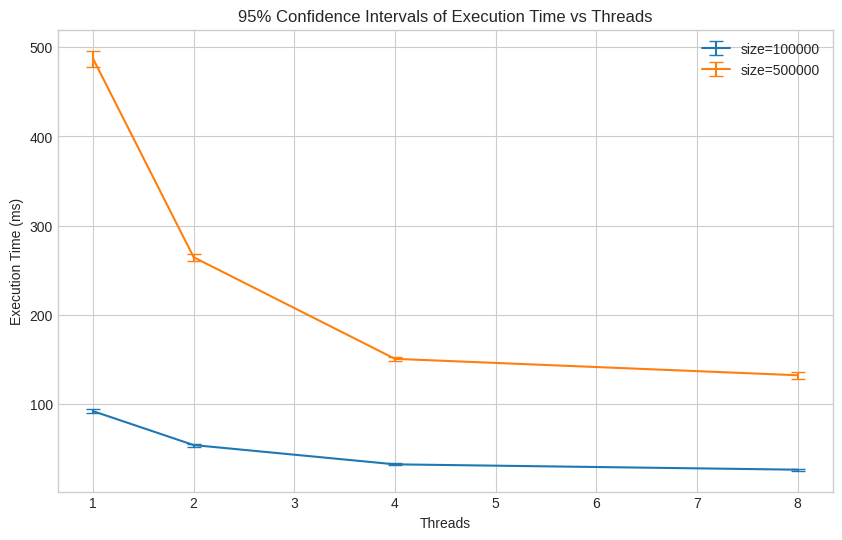

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sizes = sorted(ci_df["size"].unique())

for s in sizes:
    subset = ci_df[ci_df["size"] == s]
    plt.errorbar(
        subset["threads"],
        subset["mean_time"],
        yerr=subset["ci"],
        capsize=5,
        label=f"size={s}"
    )

plt.title("95% Confidence Intervals of Execution Time vs Threads")
plt.xlabel("Threads")
plt.ylabel("Execution Time (ms)")
plt.legend()
plt.show()


### 95% CI of Execution Time vs Threads — Interpretation

This plot shows how execution time changes as thread count increases,
for two different input sizes (100k and 500k).

#### 1. For Both Sizes: Clear Decreasing Trend
Execution time decreases sharply from:
- **1 → 2 threads**
- **2 → 4 threads**

This corresponds to the main benefit of parallelism.

#### 2. Diminishing Returns
After 4 threads, the slope becomes almost flat:

- For size=100k: 4 → 8 threads brings very little improvement.
- For size=500k: 4 → 8 threads yields a small improvement but with overlap of CIs.

This visualizes Amdahl’s Law:

> Beyond a certain number of threads, adding more threads does not proportionally reduce execution time.

Parallel overhead, cache contention, and scheduling effects limit scalability.

#### 3. Confidence Intervals Behavior
- For size=100k, CIs are very tight → stable performance.
- For size=500k, CIs are broader → more variability due to longer computations.

However, in both cases:

> The CIs for 4 and 8 threads overlap significantly.

This means:
- We cannot claim that 8 threads is faster than 4 threads **with statistical confidence**.
- The small improvement is not statistically significant.

#### 4. Key Observations
- Single-thread performance is deterministic → narrow CIs.
- Parallelism introduces nondeterminism → wider CIs.
- Larger inputs amplify variability.
- True performance gains must be judged by non-overlapping CIs, not raw means.

#### 5. Conclusion
This plot demonstrates the SMPE principles:

- Always analyze performance with CIs, not only means.
- Multithreading reduces time but increases variance.
- After 4 threads, speedup becomes statistically weak.
- Some apparent improvements are not significant.

This emphasizes the importance of **statistical analysis** in performance evaluation.


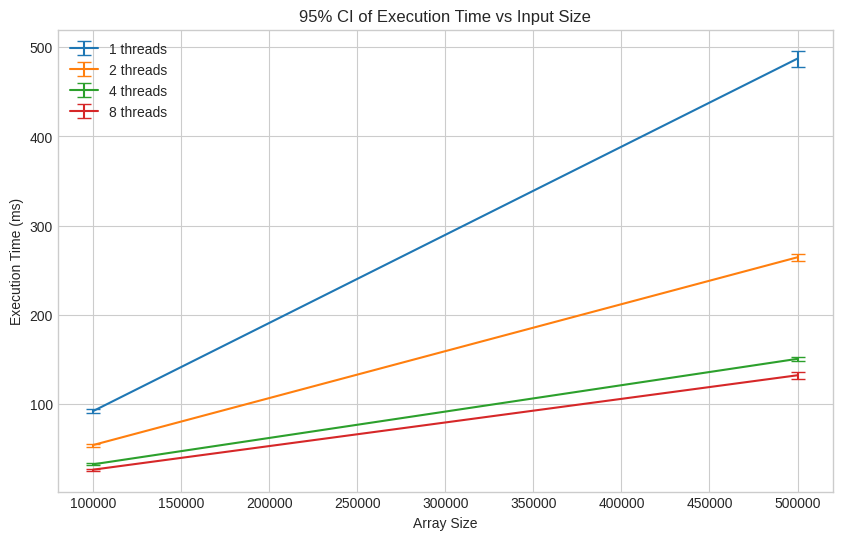

In [19]:
plt.figure(figsize=(10,6))

threads = sorted(ci_df["threads"].unique())

for t in threads:
    subset = ci_df[ci_df["threads"] == t]
    plt.errorbar(
        subset["size"],
        subset["mean_time"],
        yerr=subset["ci"],
        capsize=5,
        label=f"{t} threads"
    )

plt.title("95% CI of Execution Time vs Input Size")
plt.xlabel("Array Size")
plt.ylabel("Execution Time (ms)")
plt.legend()
plt.show()


### 95% CI of Execution Time vs Input Size — Interpretation

This plot shows how execution time grows with input size for each thread count, with
95% confidence intervals.

#### 1. Effect of Input Size
Execution time increases almost linearly with size for all thread counts.  
This is expected because Quicksort has complexity O(n log n), which for large n
appears nearly linear.

#### 2. Effect of Threads
- **1 thread** is by far the slowest for all input sizes.
- As the number of threads increases from **1 → 2 → 4 → 8**, execution time decreases.
- The curves become closer together at high thread count → diminishing returns.

This is consistent with parallel algorithms: overhead and resource contention limit speedup.

#### 3. Width of Confidence Intervals
- CI width is **small** relative to the mean, indicating stable measurements.
- CIs become **slightly wider** for larger input sizes because there is more work,
thus more variability.
- Higher thread counts tend to show *slightly larger* CIs, reflecting
parallel execution nondeterminism (scheduler noise, load imbalance).

#### 4. Overlap of CIs
For some input sizes, the CIs of 4 threads and 8 threads overlap.

This implies:

> The performance difference between 4 and 8 threads is **not statistically significant**.

This is an important SMPE lesson:  
**You must not claim a performance improvement when the CIs overlap,
even if the mean time looks smaller.**

#### 5. Conclusion
The plot reveals:
- Strong dependency on input size
- Real but diminishing benefits from parallelism
- Low variability overall, but increasing with threads and size
- Some speedups are not statistically meaningful

This supports the need for CI-based reasoning in performance evaluation.
